In [1]:
import os
from dotenv import load_dotenv
load_dotenv() ## aloading all the environment variable

True

In [22]:
from langchain_community.tools import DuckDuckGoSearchRun

web_search_tool = DuckDuckGoSearchRun()

web_search_tool.invoke("What are the different types of memory used by intelligent agents?")

"In this article, we break down the AI agent memory types that underpin intelligent, agentic behavior. You'll learn how different memory types are used, what frameworks support them, and how to design hybrid memory architectures for real-world applications. Discover the crucial role of memory in AI agents. This guide breaks down different memory types, from immediate processing to deep, experiential learning, and how they drive AI intelligence. Learn how long-term, short-term, and dynamic memory work in AI agents. Train, manage, and optimize your agents for smarter, more accurate conversations. In conclusion, effective memory management is crucial for building intelligent agents that can provide meaningful and contextually relevant interactions. By understanding the limitations of context length, model comprehension, and cost, we can develop more efficient solutions. Learn about the different types of agent memory, the crucial role of persistence, and how vector storage empowers intell

In [45]:
### Build Vectordb

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_google_genai import GoogleGenerativeAIEmbeddings

# Docs to index: Langchain and langgraph
urls = [
    "https://www.langchain.com/",
    "https://www.langchain.com/langgraph-platform"
]

# Load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorstore
vectorstore=FAISS.from_documents(
    documents=doc_splits,
    embedding=GoogleGenerativeAIEmbeddings(model="models/embedding-001")
)

retriever=vectorstore.as_retriever()
retriever.invoke("langchain")

[Document(id='f40178c2-1624-424d-9821-62c5dd523e7c', metadata={'source': 'https://www.langchain.com/', 'title': 'LangChain', 'description': 'LangChain’s suite of products supports developers along each step of their development journey.', 'language': 'en'}, page_content="LangChain products are designed to be used independently or stack for multiplicative benefit. LangChainLangGraphFrameworksLangSmithLangGraph PlatformPlatformsFrameworksLangChainLangGraphPlatformsLangSmithLangGraph \u2028PlatformSTACK 1:\xa0LangGraph +\xa0LangChain +\xa0LangSmith +\xa0LangGraph\xa0PlatformA full product suite for reliable agents and LLM appsLangChain's products work seamlessly together to provide an integrated solution for every step of the application development journey. When you use all LangChain products, you'll build better, get to production quicker, and grow visibility -- all with less set up and friction. LangChain provides the smoothest path to high quality agents.Orchestration:Integrations:Eva

In [29]:
### Retrieval Grader

from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from pydantic import BaseModel, Field

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

# LLM with function call
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)
##chain the prompt with the LLM
retrieval_grader = grade_prompt | structured_llm_grader
question = "bangalore news"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='no'


In [5]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

d:\agent-course\venv\Lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


I'm sorry, but I cannot provide information about Bangalore news with the context provided. The documents discuss LangChain's products, platforms, and features for building and deploying AI agents. There is no mention of Bangalore or any news related to it.


In [44]:
### Question Re-writer

# LLM
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
question = "machine learning"

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and comeup with a refined question by trying to reason about the underlying semantic intent / meaning. Please come up with the best option only."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
output = question_rewriter.invoke({"question": question})
print(output)
web_search_tool.invoke(output)

What are the latest advancements and applications of machine learning?


"Lev Craig covers AI and machine learning as site editor for TechTarget's Enterprise AI site. Craig graduated from Harvard University with a bachelor's degree in English and has previously written about enterprise IT, software development and cybersecurity. Next Steps. The year in AI: Catch up on the top AI news of 2024 Machine learning is growing rapidly and is expected to reach a market size of USD 666.16 billion by 2032, driven by technological advancements and increasing demand. We will analyze significant trends in deep learning and reinforcement learning , along with the rapid advances in explainability and ethical AI, and explore how these trends will ... Reinforcement learning starts tackling real-world challenges Meta's AI plays diplomacy game. Facebook and Meta have invested heavily in a subfield of machine learning called reinforcement learning (RL), which trains agent behavior through environmental rewards and penalties. Meta scientists reported an RL agent that learned to 

In [49]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]

In [50]:
from langchain.schema import Document

def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    print("question----" + question)
    docs = web_search_tool.invoke({"query": question})
    print("web search docs----" + docs)
    documents.append(Document(page_content=docs))

    return {"documents": documents, "question": question}


### Edges


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [51]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search_node", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

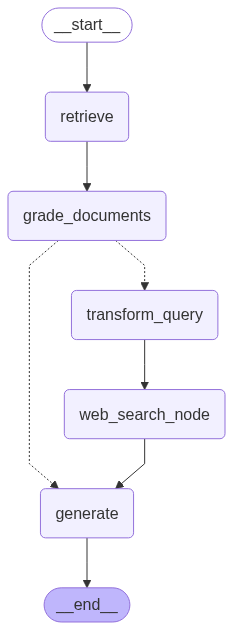

In [52]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [54]:
app.invoke({"question": "what is langchain"})

---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---


{'question': 'what is langchain',
 'generation': 'LangChain is a suite of products designed to support developers throughout their development journey. It can be used independently or stacked for multiplicative benefit. It helps teams drive operational efficiency, increase discovery & personalization, and deliver premium products.',
 'web_search': 'No',
 'documents': [Document(id='f40178c2-1624-424d-9821-62c5dd523e7c', metadata={'source': 'https://www.langchain.com/', 'title': 'LangChain', 'description': 'LangChain’s suite of products supports developers along each step of their development journey.', 'language': 'en'}, page_content="LangChain products are designed to be used independently or stack for multiplicative benefit. LangChainLangGraphFrameworksLangSmithLangGraph PlatformPlatformsFrameworksLangChainLangGraphPlatformsLangSmithLangGraph \u2028PlatformSTACK 1:\xa0LangGraph +\xa0LangChain +\xa0LangSmith +\xa0LangGraph\xa0PlatformA full product suite for reliable agents and LLM app